In [61]:
import pandas as pd
import pandas_datareader.data as pdr
from datetime import datetime
import yfinance as yf
import numpy as np
import talib as tb
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler

from skopt import BayesSearchCV 

from imblearn.pipeline import Pipeline as imbPipeline

import xgboost as xgb
from code_.backtester import Backtester

In [2]:
plt.rcParams['figure.figsize'] = 15, 7

# 1. Data Retrieval
### Specify query parameters

In [3]:
symbol ='BTC-USD'
#symbol ='QQQ'

start = datetime(2014, 1, 1)
end = datetime(2020, 10, 4)

### Get data using Yahoo API

In [39]:
stock = pdr.get_data_yahoo(symbol, start, end, interval='d')
stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800.0,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200.0,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700.0,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600.0,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100.0,398.821014


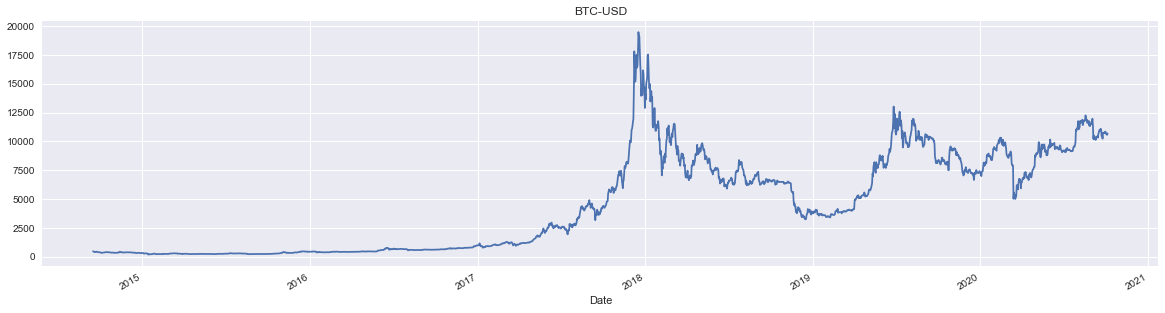

In [40]:
stock.columns = list(stock.columns.str.lower())
stock['volume'] = stock['volume'].astype(float)
stock['open'].plot(figsize=(20,5), title=f'{symbol}'), plt.show();

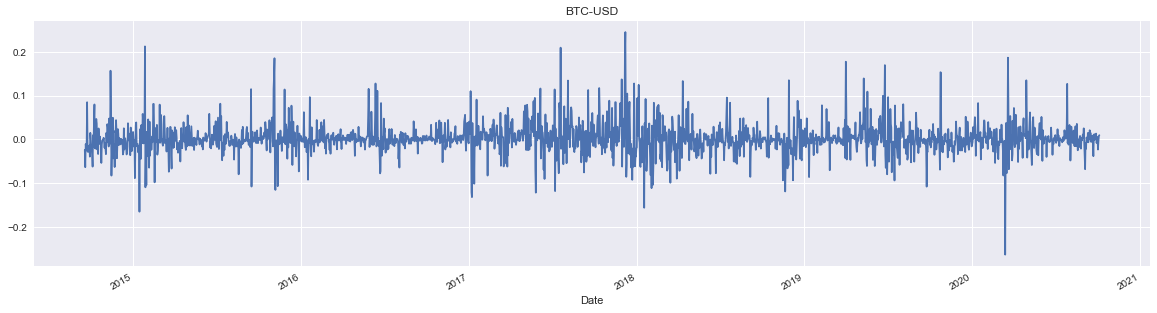

In [41]:
stock['high'].pct_change().plot(figsize=(20,5), title=f'{symbol}'), plt.show();

### Data Transformation: labelling and TA features

In [32]:
class ColumnExtractor(object):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

In [71]:
#Technical features
high = stock['high'].values
low = stock['low'].values
volume = stock['volume'].values
# define the technical analysis matrix
retn = np.array([
    tb.MA(high, timeperiod=5),                                         # 1
    tb.MA(high, timeperiod=10),                                        # 2
    tb.MA(high, timeperiod=20),                                        # 3
    tb.MA(high, timeperiod=60),                                        # 4
    tb.MA(high, timeperiod=90),                                        # 5
    tb.MA(high, timeperiod=120),                                       # 6

    tb.MACD(high, fastperiod=12, slowperiod=26, signalperiod=9)[0],    # 9
    tb.RSI(high, timeperiod=14),                                       # 10

    tb.BBANDS(high, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0],  # 11
    tb.BBANDS(high, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1],  # 12
    tb.BBANDS(high, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2]

]).T

indic_names = ['MA5', 'MA10', 'MA20', 'MA60', 'MA90', 'MA120', 
               'MACD1216', 'RSI14', 'BBANDS_TOP', 'BBANDS_MID', 'BBANDS_BOT']


retdf = pd.DataFrame(retn, columns=indic_names)
retdf['date'] = stock.index.values
retdf.set_index('date', inplace=True)
expanded_data = stock.join(retdf)

In [72]:
expanded_data

,high,low,open,close,volume,adj close,MA5,MA10,MA20,MA60,MA90,MA120,MACD1216,RSI14,BBANDS_TOP,BBANDS_MID,BBANDS_BOT
2014-09-16,468.174011,452.421997,465.864014,457.334015,2.105680e+07,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-17,456.859985,413.104004,456.859985,424.440002,3.448320e+07,424.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,427.834991,384.532013,424.102997,394.795990,3.791970e+07,394.795990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,423.295990,389.882996,394.673004,408.903992,3.686360e+07,408.903992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-20,412.425995,393.181000,408.084991,398.821014,2.658010e+07,398.821014,437.718195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,480.043960,437.718195,395.392430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30,10915.843750,10493.552734,10785.010742,10623.330078,2.717823e+10,10623.330078,10877.033398,10789.293555,10858.917578,11330.607438,10809.977365,10494.233439,-55.733933,50.011320,10977.744634,10877.033398,10776.322163
2020-10-01,10662.813477,10440.311523,10624.390625,10585.164062,2.312784e+10,10585.164062,10848.649609,10798.767187,10863.116357,11307.751921,10826.204796,10502.399723,-66.934659,42.152156,11047.270832,10848.649609,10650.028387
2020-10-02,10614.091797,10527.978516,10583.806641,10565.493164,1.709401e+10,10565.493164,10781.643359,10796.391602,10864.960205,11293.768799,10842.102528,10508.453735,-78.833998,40.821898,11021.286854,10781.643359,10541.999865
2020-10-03,10700.791016,10531.342773,10567.919922,10684.428711,1.754679e+10,10684.428711,10750.013672,10789.891211,10859.999219,11275.671696,10859.198166,10515.383350,-80.342272,44.196738,10982.128273,10750.013672,10517.899071


In [101]:
#percent change for every feature
leaky_features = ['open', 'close', 'adj close']
filtered_data = expanded_data.drop(leaky_features, axis=1)

for feat in filtered_data.columns:
    filtered_data[f'{feat}_pct_chg'] = filtered_data[feat].pct_change()
    
filtered_data = filtered_data.replace([np.inf, -np.inf], np.nan).dropna()

In [102]:
filtered_data['tmrw_pct_chg'] = filtered_data['high_pct_chg'].shift(-1)
filtered_data.dropna(inplace=True)

In [103]:
X = filtered_data.drop(['high_pct_chg', 'tmrw_pct_chg'], axis=1)
X.columns = [str(col) for col in X.columns]

y = filtered_data['tmrw_pct_chg']

In [104]:
filtered_data.columns

Index(['high', 'low', 'volume', 'MA5', 'MA10', 'MA20', 'MA60', 'MA90', 'MA120',
       'MACD1216', 'RSI14', 'BBANDS_TOP', 'BBANDS_MID', 'BBANDS_BOT',
       'high_pct_chg', 'low_pct_chg', 'volume_pct_chg', 'MA5_pct_chg',
       'MA10_pct_chg', 'MA20_pct_chg', 'MA60_pct_chg', 'MA90_pct_chg',
       'MA120_pct_chg', 'MACD1216_pct_chg', 'RSI14_pct_chg',
       'BBANDS_TOP_pct_chg', 'BBANDS_MID_pct_chg', 'BBANDS_BOT_pct_chg',
       'tmrw_pct_chg'],
      dtype='object')

# 2. Modelling

In [105]:
#Split the given training data further so as to validate performance
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=0,
                                                    shuffle=False,
                                                    test_size=0.15
                                            )

#specify numeric features
numerical_features = X.columns

In [106]:
#numeric transformations
numeric_transformer = Pipeline(steps=[
    ('extract', ColumnExtractor(columns=numerical_features)),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True))
])

#categorical transformations
# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))|
# ])

#package transformations into another pipe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features)
    ])

#define feature selection strategy
clf = ExtraTreesRegressor(n_estimators=100)
reducer = SelectFromModel(clf)

#scaler
scaler = StandardScaler()

estimator = xgb.XGBRegressor(objective='reg:squarederror')

#pack it up
mdl = imbPipeline(steps=[('preprocessor', preprocessor),
                         ('reducer', reducer),
                         ('scaler', scaler),
                         ('estimator', estimator)])

### Tune hyperparameters

In [107]:
#Define search space
# n_estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=10)]
# max_depth = [int(x) for x in np.linspace(4, 20, num=10)]
# learning_rate = [float(x) for x in np.linspace(start=0.005, stop=0.1, num=10)]
# gamma = [float(x) for x in np.linspace(start=0, stop=0.4, num=10)]
# min_child_weight = [float(x) for x in np.linspace(start=0, stop=10, num=10)]
# colsample_by_tree = [0.3, 0.5, 0.7, 1]

#Using small search space for debugging
param_grid  = {
                'estimator__learning_rate': (0.01, 1.0, 'log-uniform'),
                'estimator__min_child_weight': (0.1, 10),
                'estimator__max_depth': (2, 50),
                'estimator__max_delta_step': (2, 20),
                'estimator__colsample_bytree': (0.01, 1.0, 'uniform'),
                'estimator__gamma': (1e-9, 0.5, 'log-uniform'),
                'estimator__n_estimators': (100, 150)
}

tuner = BayesSearchCV(estimator=mdl,
                      search_spaces=param_grid,
                      n_iter=10,
                      cv=4,
                      scoring='r2',
                      n_jobs=-1,
                      verbose=10)

tuner.fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   30.2s remaining:   30.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   30.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   18.3s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   29.3s remaining:   29.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   30.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   30.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   22.0s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   18.4s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   28.9s remaining:   28.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   30.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   30.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   29.4s remaining:   29.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   29.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   29.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   21.2s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   30.2s remaining:   30.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   32.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   32.5s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   26.0s remaining:   26.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   26.3s finished


BayesSearchCV(cv=4,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('extract',
                                                                                           <__main__.ColumnExtractor object at 0x000001D791A6B8C8>),
                                                                                          ('poly',
                                                                                           PolynomialFeatures(interaction_only=True))]),
                                                                          Index(['high', 'low', 'volume', 'MA5', 'MA10', 'MA20', 'MA60', 'MA90', 'MA120',
       'MACD1216', 'RSI14', 'BBANDS_TOP', 'BBANDS_MID',...
                                         XGBRegressor(objective='reg:squarederror'))]),
              n_iter=10, n_jobs=-1, scoring='r2',
    

#### Evaluate model

In [108]:
y_pred = tuner.predict(X_test)

print(f'overall R2: {r2_score(y_test, y_pred)}')

overall R2: 0.23325658616191802


In [109]:
tuner.best_params_

OrderedDict([('estimator__colsample_bytree', 0.28395256271242614),
             ('estimator__gamma', 0.023050481597123897),
             ('estimator__learning_rate', 0.07335838186774842),
             ('estimator__max_delta_step', 16),
             ('estimator__max_depth', 33),
             ('estimator__min_child_weight', 7.75923500529753),
             ('estimator__n_estimators', 111)])

In [110]:
y_comparisons = pd.DataFrame()
y_comparisons['y_test'] = y_test
y_comparisons['y_pred'] = y_pred

y_comparisons.head()

,y_test,y_pred
2019-11-25,0.000051,-0.021124
2019-11-26,0.040909,0.005016
2019-11-27,0.014486,-0.002795
2019-11-28,0.006611,0.006176
2019-11-29,0.007058,0.005737


<AxesSubplot:>

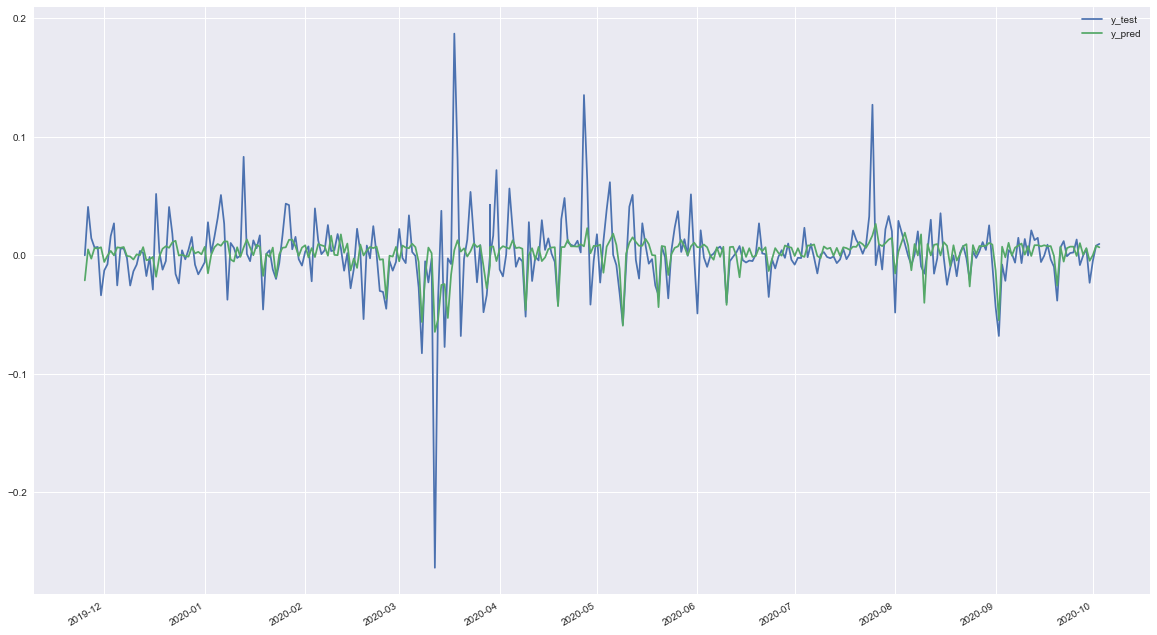

In [111]:
y_comparisons.plot(figsize=(20,12))